In [1]:
import os
ROOT = os.path.dirname(os.path.dirname(os.getcwd()))
print(ROOT)

/home/saisampathkedari/MonteCarlo-Statistical-Methods


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
from mcmc.algorithms.adaptive_metropolis import *
from mcmc.distributions.banana import *
from mcmc.utils.mcmc_utils import *
from mcmc.diagnostics.autocorrelation import *
from mcmc.utils.run_helpers import *
from mcmc.diagnostics.iac_and_ess import *

## Target Disribution : Banana Distribution

In [4]:
target_pdf_banana = pdf_banana_eval
target_logpdf_banana = logpdf_banana_eval

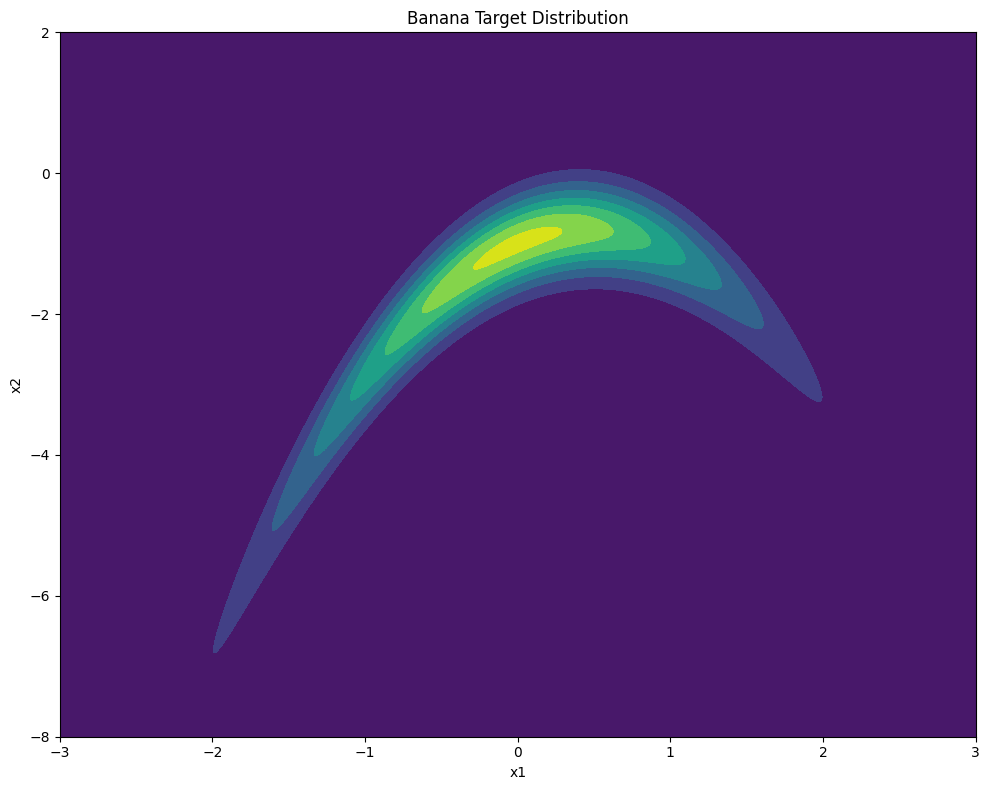

In [5]:
plt.figure(1, figsize=(10,8))

xgrid = np.linspace(-3,3,400)
ygrid = np.linspace(-8,2,400)

XX, YY, logpdf_evals = eval_on_2D_grid(xgrid, ygrid, target_pdf_banana)

plt.contourf(XX, YY, logpdf_evals)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Banana Target Distribution")
save_path_1 = os.path.join(ROOT, "images/mcmc/Banana_target_distribution.png")
plt.tight_layout()
plt.savefig(save_path_1)
plt.show()

## Target Distribution and Laplace Approximation

In [6]:
laplace_mean = np.array([0,-1])
laplace_cov = build_2D_covariance_matrix(1.0,1.0,0.9)



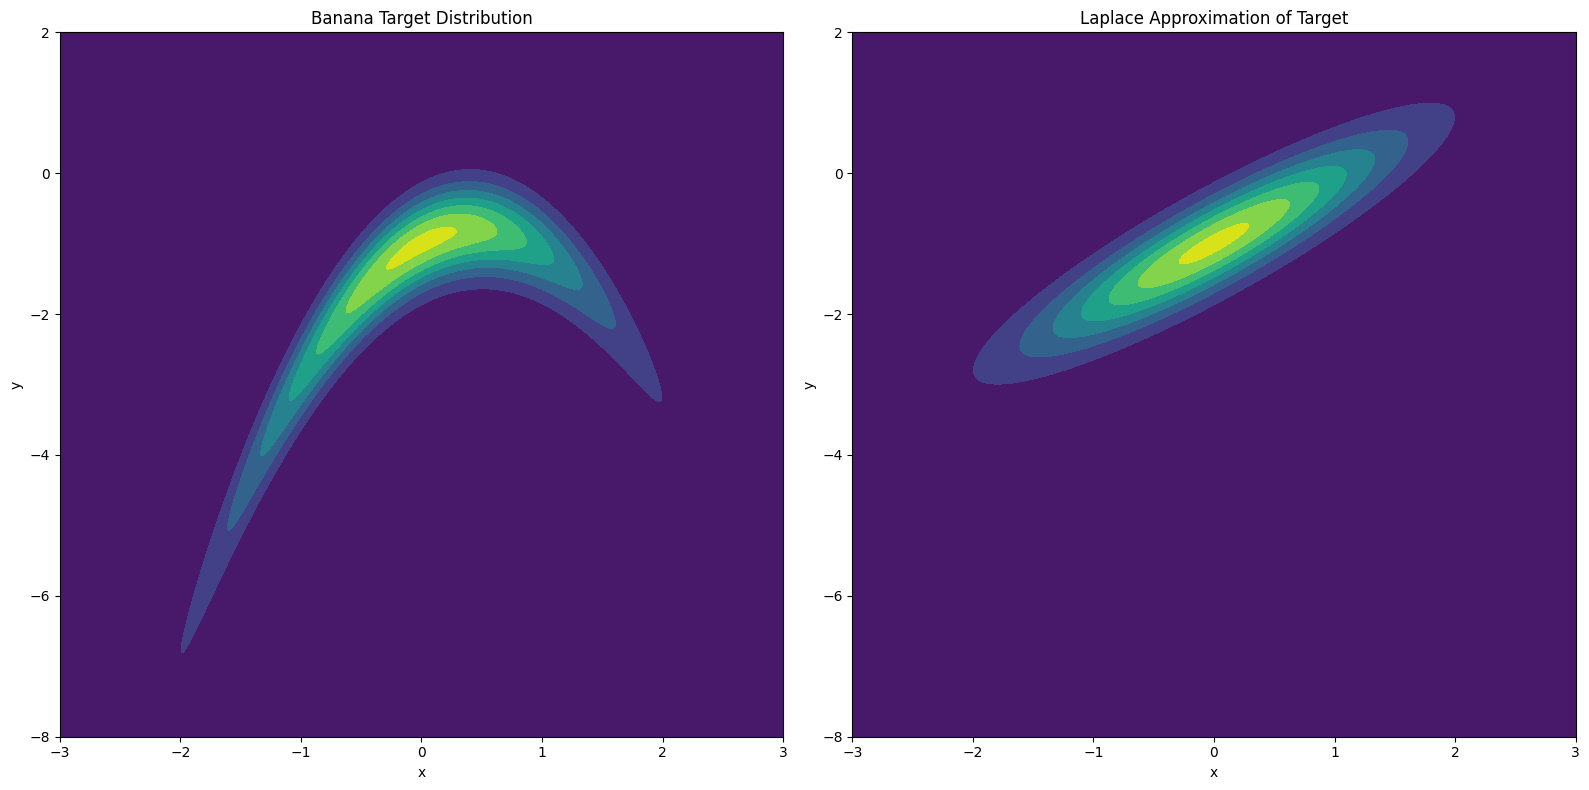

In [7]:
# -------------------------------------------------------
# 1. Define the grid
# -------------------------------------------------------
xgrid = np.linspace(-3, 3, 400)
ygrid = np.linspace(-8, 2, 300)

# -------------------------------------------------------
# 2. Evaluate Target distribution
# -------------------------------------------------------
XX, YY, target_vals = eval_on_2D_grid(
    xgrid,
    ygrid,
    target_pdf_banana)

# -------------------------------------------------------
# 3. Evaluate Laplace Approximation (Gaussian)
# -------------------------------------------------------
gauss_mean = laplace_mean
gauss_cov = laplace_cov

target_pdf_2d_Gaussian = lambda x: pdf_multivariate_normal_eval(x, gauss_mean, gauss_cov)

# Use scipy Gaussian evaluator on grid
XX, YY, laplace_target_vals = eval_on_2D_grid(
    xgrid,
    ygrid,
    target_pdf_2d_Gaussian)

# -------------------------------------------------------
# 4. Plot both distributions
# -------------------------------------------------------
plt.figure(figsize=(16, 8))

# Left subplot: Target Distribution
ax1 = plt.subplot(1, 2, 1)
ax1.contourf(XX, YY, target_vals)
ax1.set_title("Banana Target Distribution")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_xlim(-3, 3)
ax1.set_ylim(-8, 2)

# Right subplot: Laplace approximation
ax2 = plt.subplot(1, 2, 2)
ax2.contourf(XX, YY, laplace_target_vals)
ax2.set_title("Laplace Approximation of Target")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_xlim(-3, 3)
ax2.set_ylim(-8, 2)
save_path_1 = os.path.join(ROOT, "images/mcmc/Banana_and_LaplaceApproximation.png")
plt.tight_layout()
plt.savefig(save_path_1)
plt.show()


# Adaptive Metropolis for Banana Distribution

In [8]:
# initial conditions
initial_sample = laplace_mean
initial_cov = laplace_cov # from Laplace Approximation
num_samples = 50000

# Proposal Distribution properties
proposal_logpdf = proposal_mvn_logpdf_eval
proposal_sampler = proposal_mvn_sampler


## Adaptive-Metropolis 
am_result = am_mcmc(initial_sample, initial_cov, num_samples, target_logpdf_banana, proposal_logpdf, proposal_sampler, freq_of_update=200, verbose=True)

samples = am_result.samples
print("Accepted Samples Ratio:", am_result.accept_rate)

Finished sample 1000, acceptance ratio = 0.117
Finished sample 2000, acceptance ratio = 0.119
Finished sample 3000, acceptance ratio = 0.123
Finished sample 4000, acceptance ratio = 0.123
Finished sample 5000, acceptance ratio = 0.125
Finished sample 6000, acceptance ratio = 0.132
Finished sample 7000, acceptance ratio = 0.132
Finished sample 8000, acceptance ratio = 0.132
Finished sample 9000, acceptance ratio = 0.133
Finished sample 10000, acceptance ratio = 0.131
Finished sample 11000, acceptance ratio = 0.134
Finished sample 12000, acceptance ratio = 0.137
Finished sample 13000, acceptance ratio = 0.138
Finished sample 14000, acceptance ratio = 0.140
Finished sample 15000, acceptance ratio = 0.141
Finished sample 16000, acceptance ratio = 0.140
Finished sample 17000, acceptance ratio = 0.140
Finished sample 18000, acceptance ratio = 0.141
Finished sample 19000, acceptance ratio = 0.141
Finished sample 20000, acceptance ratio = 0.141
Finished sample 21000, acceptance ratio = 0.141
F

## Burn-In

In [9]:
new_am_result= mcmc_burnin_and_thin(am_result, burnin_frac=0.5, thin_frac=1)
samples = new_am_result.samples
print("Accepted Samples Ratio:", new_am_result.accept_rate)

Accepted Samples Ratio: 0.12976


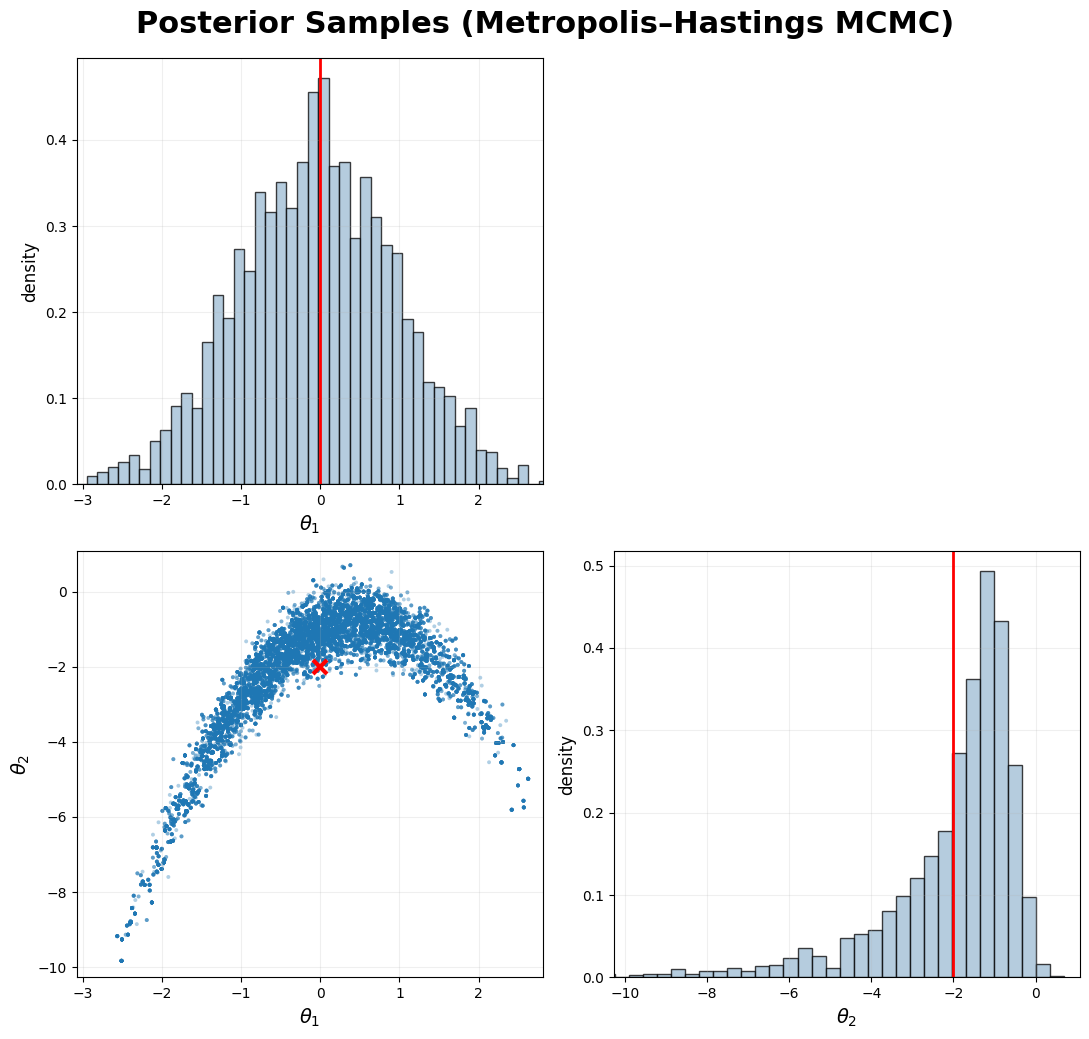

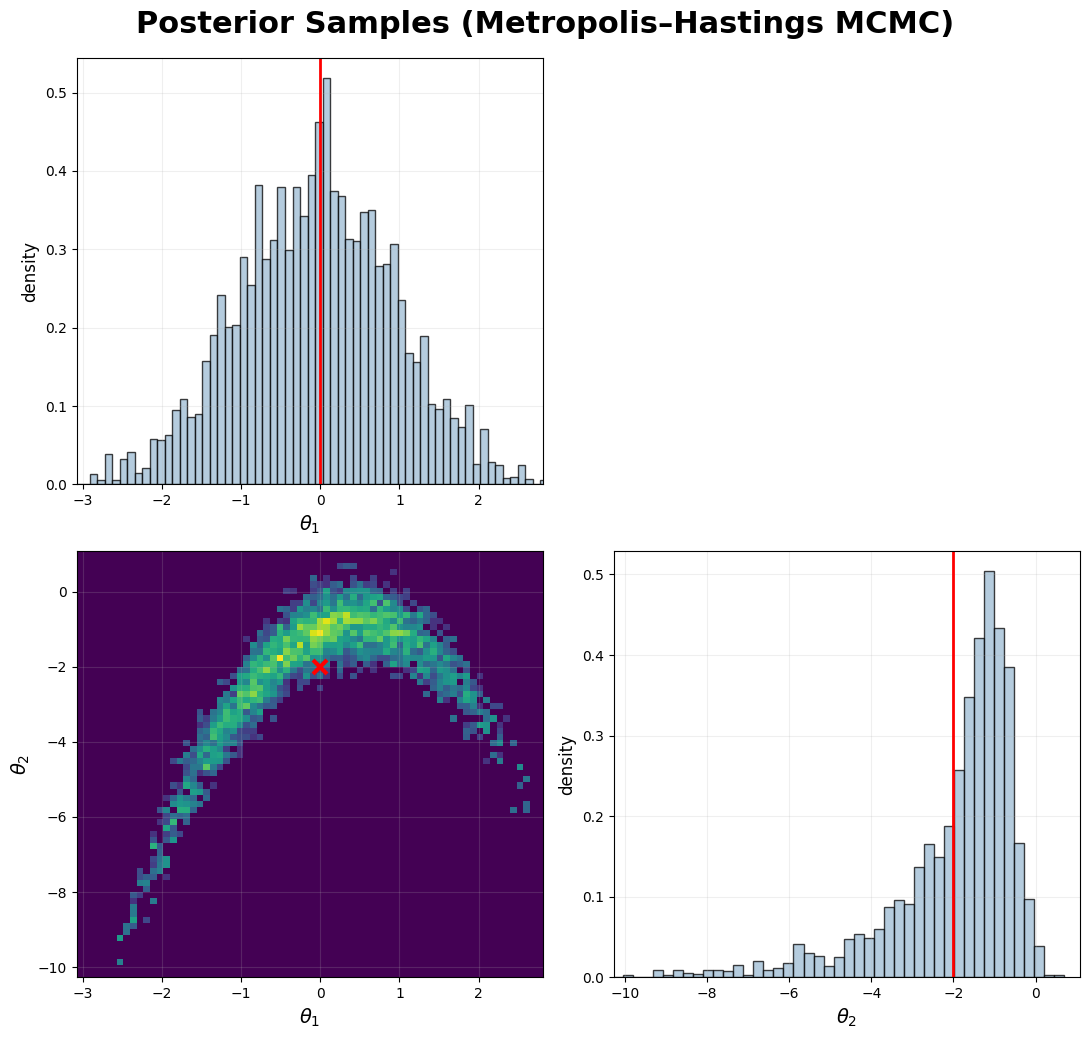

In [10]:
true_mean = np.array([0,-2])

plt.close()
fig, axs, gs = scatter_matrix_clean(
    11,
    [samples],
    truths=true_mean,          # or None
    labels=[r"$\theta_1$", r"$\theta_2$"],
    hist_plot=False,
)
save_path_2 = os.path.join(ROOT, "images/mcmc/MH_samples1_banana.png")
plt.savefig(save_path_2)
plt.show()

plt.close(12)
fig, axs, gs = scatter_matrix_clean(
    12,
    [samples],
    truths=true_mean,
    labels=[r"$\theta_1$", r"$\theta_2$"],
    hist_plot=True,
    nbins=70
)
save_path_3 = os.path.join(ROOT, "images/mcmc/MH_samples2_banana.png")
plt.savefig(save_path_3)
plt.show()

## Estimation of Mean

In [11]:
print("True Mean        = ", np.array([0,-2]))
print("Estimated Mean   = ", np.mean(samples, axis=0))

True Mean        =  [ 0 -2]
Estimated Mean   =  [-0.0473013  -2.05011345]


## Mixing

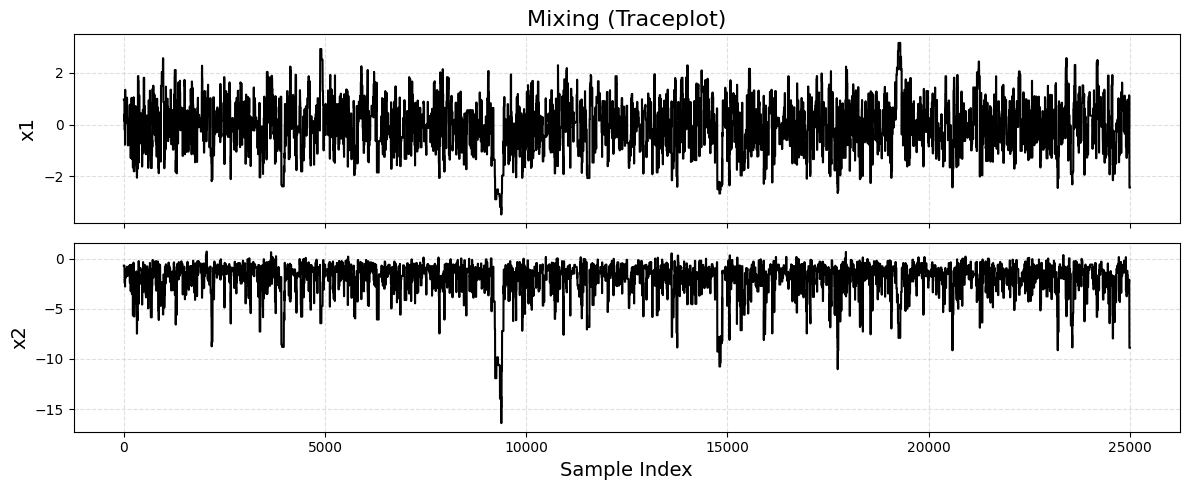

In [12]:
save_path_3 = os.path.join(ROOT, "images/mcmc/Mixing_MH_banana.png")
plot_mixing_2d(samples, dim_names=("x1", "x2"), save_path=save_path_3)

## Autocorrelation

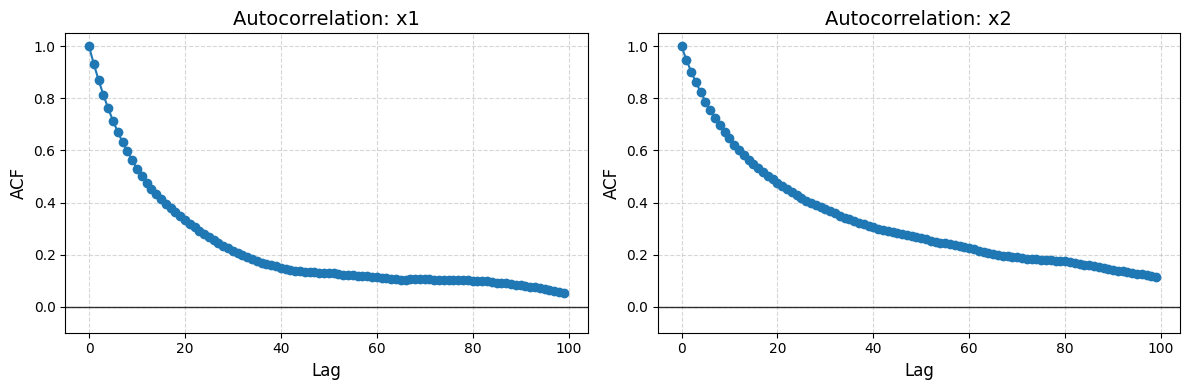

In [13]:
lags, acf = autocorrelation_vectorized(samples, max_lag=100)

save_path_4 = os.path.join(ROOT, "images/mcmc/AutoCorr_MH_banana.png")
plot_autocorrelation_2d(lags, acf, dim_names=("x1", "x2"), save_path=save_path_4)

## Integrated Auto-Correlation & Effective Sample Size

In [14]:
iac, acf, lags = integrated_autocorrelation(samples, max_lag=300)
ess = effective_sample_size(samples, iac)

N = samples.shape[0]
efficiency = ess / N * 100  # percentage

print(f"Total samples: {N}\n")

for k in range(len(iac)):
    print(f"Dimension {k}:")
    print(f"  IAC:          {iac[k]:.4f}")
    print(f"  ESS:          {ess[k]:.2f}")
    print(f"  Efficiency:   {efficiency[k]:.1f}%   "
          f"({efficiency[k]:.1f}% as effective as independent samples)")
    print()


Total samples: 25000

Dimension 0:
  IAC:          51.2282
  ESS:          488.01
  Efficiency:   2.0%   (2.0% as effective as independent samples)

Dimension 1:
  IAC:          75.5393
  ESS:          330.95
  Efficiency:   1.3%   (1.3% as effective as independent samples)

